Source codes for Python Machine Learning By Example 4th Edition (Packt Publishing)

Chapter 14 Building an Image Search Engine Using Multimodal Models

Author: Yuxi (Hayden) Liu (yuxi.liu.ece@gmail.com)

# Getting started with the dataset

## Loading the Flickr8k dataset

In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

/home/oreo/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_hip.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
image_dir = "flickr8k/Flicker8k_Dataset"
caption_file = "flickr8k/captions.txt"

In [3]:
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [4]:
class Flickr8kDataset(Dataset):
    def __init__(self, image_dir, caption_file):
        self.image_dir = image_dir
        self.transform = transforms.Compose([
                            transforms.Resize((224, 224)),
                            transforms.ToTensor(),
                         ])
        self.image_paths, self.captions = self.read_caption_file(caption_file)

    def read_caption_file(self, caption_file):
        image_paths = []
        captions = []

        with open(caption_file, "r") as file:
            lines = file.readlines()
            for line in lines[1:]:
                parts = line.strip().split(",")
                image_paths.append(os.path.join(self.image_dir, parts[0]))
                captions.append(parts[1])
        
        self.caption_encodings = tokenizer(captions, truncation=True, padding=True, max_length=200)
            
        return image_paths, captions

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.caption_encodings.items()}
        
        caption = self.captions[idx]
        item["caption"] = caption
        
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
        item['image'] = img

        return item

In [5]:
flickr8k_dataset = Flickr8kDataset(image_dir=image_dir, caption_file=caption_file)

In [6]:
item_sample = next(iter(flickr8k_dataset))


In [7]:
item_sample

{'input_ids': tensor([ 101, 1037, 2775, 1999, 1037, 5061, 4377, 2003, 8218, 2039, 1037, 2275,
         1997, 5108, 1999, 2019, 4443, 2126, 1012,  102,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'caption': 'A child in a pink dress is climbing up a set of stairs in an entry way .',
 'image': tensor([[[0.3216, 0.4353, 0.4549,  ..., 0.0157, 0.0235, 0.0235],
          [0.3098, 0.4431, 0.4667,  ..., 0.0314, 0.0275, 0.0471],
          [0.3020, 0.4588, 0.4745,  ..., 0.0314, 0.0275, 0.0392],
          ...,
          [0.7294, 0.5882, 0.6706,  ..., 0.8314, 0.6471, 0.6471],
          [0.6902, 0.6941, 0.8627,  ..., 0.8235, 0.6588, 0.6588],
          [0.8118, 0.8196, 0.7333,  ..., 0.8039, 0.6549, 0.6627]],
 
         [[0.3412, 0.5020, 0.5255,  ..., 0.0118, 

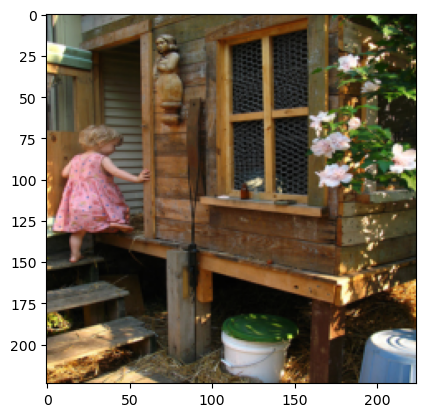

In [8]:
import matplotlib.pyplot as plt
import numpy as np

npimg = item_sample['image'].numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
 

In [9]:
torch.manual_seed(0)
batch_size = 32
data_loader = DataLoader(flickr8k_dataset, batch_size=batch_size, shuffle=True)

# Architecting the CLIP model

## Vision encoder

In [10]:
import torch.nn as nn
from torchvision.models import resnet50

class VisionEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        pretrained_resnet50 = resnet50(pretrained=True)
        self.model = nn.Sequential(*list(pretrained_resnet50.children())[:-1])

        for param in self.model.parameters():
            param.requires_grad = False

    def forward(self, x):
        x= self.model(x)
        x = x.view(x.size(0), -1)
        return x
    

## Text encoder 

In [11]:
from transformers import DistilBertModel


class TextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = DistilBertModel.from_pretrained('distilbert-base-uncased')
        for param in self.model.parameters():
            param.requires_grad = False

    def forward(self, input_ids, attention_mask=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state[:, 0, :]

## Projection head for contractive learning 

In [12]:
class ProjectionHead(nn.Module):
    def __init__(self, embedding_dim, projection_dim=256, dropout=0.1):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projection = self.projection(x)
        x = self.gelu(projection)
        x = self.fc(x)
        x = self.dropout(x)
        x = projection + x
        x = self.layer_norm(x)
        return x
    

## CLIP model

In [13]:
import torch.nn.functional as F

class CLIPModel(nn.Module):
    def __init__(self, image_embedding=2048, text_embedding=768):
        super().__init__()
        self.vision_encoder = VisionEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)

    def forward(self, batch):
        image_features = self.vision_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        logits = text_embeddings @ image_embeddings.T
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax((images_similarity + texts_similarity)/2 , dim=-1)
        texts_loss = F.cross_entropy(logits, targets)
        images_loss = F.cross_entropy(logits.T, targets.T)
        loss =  (images_loss + texts_loss) / 2
        return loss.mean()
        

# Finding images with words 

## Training the CLIP model

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
model = CLIPModel().to(device)

/home/oreo/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/oreo/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
def train(model, dataloader, optimizer):
    model.train()
    total_loss = 0
    b = 0
    for batch in dataloader:
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()*len(batch)
        
    return total_loss/len(dataloader.dataset)

In [18]:
num_epochs = 3 
for epoch in range(num_epochs):
    train_loss = train(model, data_loader, optimizer)
    print(f'Epoch {epoch+1} - loss: {train_loss:.4f}')

Epoch 1 - loss: 0.2509
Epoch 2 - loss: 0.1452
Epoch 3 - loss: 0.1240


## Obtaining embeddings for images and text to identify matches

In [19]:
torch.manual_seed(0)
data_loader = DataLoader(flickr8k_dataset, batch_size=batch_size, shuffle=True)
sample_batch = next(iter(data_loader))

In [20]:
batch_image_features = model.vision_encoder(sample_batch["image"].to(device))
batch_image_embeddings = model.image_projection(batch_image_features)
 

In [21]:
def search_top_images(model, image_embeddings, query, n=1):
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(device)
        for key, values in encoded_query.items()
    }
    model.eval()
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], 
            attention_mask=batch["attention_mask"])
        text_embeddings = model.text_projection(text_features)
    
    dot_similarity = text_embeddings @ image_embeddings.T
    values, indices = torch.topk(dot_similarity.squeeze(0), n)
    return indices
 

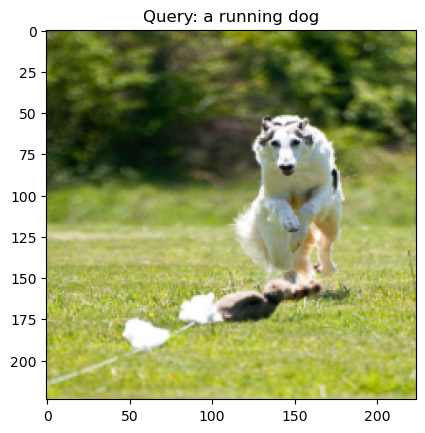

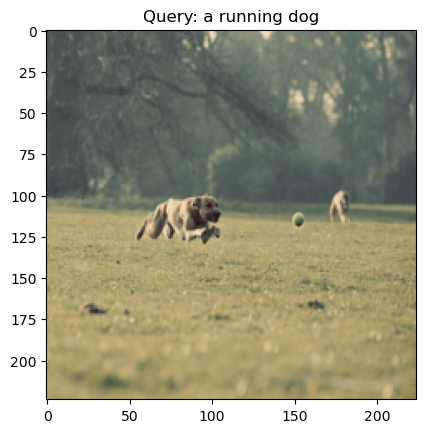

In [22]:
query = "a running dog"
top_image_ids = search_top_images(model, batch_image_embeddings, query, 2)
for id in top_image_ids:
    image = sample_batch["image"][id]
    npimg = image.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f"Query: {query}")
    plt.show()

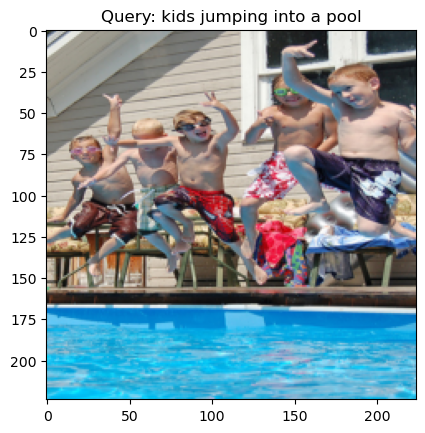

In [23]:
query = "kids jumping into a pool"
top_image_ids = search_top_images(model, batch_image_embeddings, query, 1)
for id in top_image_ids:
    image = sample_batch["image"][id]
    npimg = image.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f"Query: {query}")
    plt.show()
    

---

Readers may ignore the next cell.

In [24]:
!jupyter nbconvert --to python ch14_part1.ipynb --TemplateExporter.exclude_input_prompt=True

[NbConvertApp] Converting notebook ch14_part1.ipynb to python
[NbConvertApp] Writing 7901 bytes to ch14_part1.py
